## Ranking Objective

Police force has limitted resources and there needs to prioritize areas of interest.

- `Classification`: order of prediction do not matter
- `Ranking`: order of prediction does matter

[Website on ranking problems:](https://queirozf.com/entries/evaluation-metrics-for-ranking-problems-introduction-and-examples)

- Ranking Problems
- Sample dataset (Ground Truth)
- Precision @k
- Recall @k
- F1 @k
- AP: Average Precision
- DCG: Discounted Cumulative Gain
- NDCG: Normalized Discounted Cumulative Gain
- MAP: Mean Average Precision
- Average Precision @k
- DCG vs NDCG

In [18]:
# gained discounter cumulative gain

In [19]:
# we want to know how well our models predict the distributions for the following day

In [1]:
from sklearn.metrics import ndcg_score, average_precision_score
import numpy as np
from utils.plots import plot
from utils.data_processing import normalize_flat, normalize_grid
from utils.metrics import ndcg_per_time_slot
import scipy as sp
from utils.plots import im
from utils.data_processing import normalize_flat
from utils.preprocessing import scale_per_time_slot
from utils.preprocessing import min_max_scale
from utils.metrics import mae_per_time_slot
from models.model_result import RankingMetrics

In [2]:
from sklearn.metrics import ndcg_score

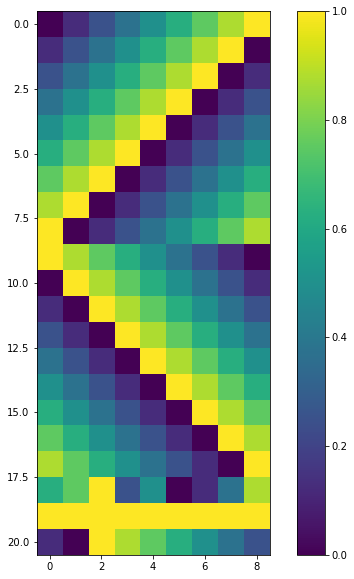

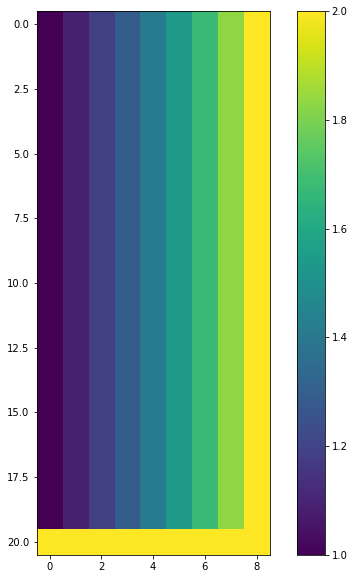


        MODEL NORMALIZED RANKING METRICS
            Class Balance (Crime:No-Crime) - 1:0.181
            Model Name: test
                NDCG:      0.739309
                MAP:       0.912646
                MAE:       0.387335
        


/home/bernard/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning:

invalid value encountered in true_divide



In [4]:
dims  = n,c,l = 28,1,9
n = 2 * l + 3


y_count = np.arange(1,1+n*l).reshape(n,c,l) # np.random.rand(n,l)
# y_score = np.arange(1,1+n*l).reshape(n,c,l)
y_score = scale_per_time_slot(np.arange(1,1+n*l).reshape(n,c,l)) #+ np.random.rand(1,c,l)*.3

for i in range(n):
    y_score[i] = np.roll(y_score[i],-1 * (i % l))
    
y_score[l:,0] = y_score[l:,0,::-1]
np.random.shuffle(y_score[-3,0])

# y_score[-1] = 1
# y_score[-1] = y_score[0]
y_count[-1] = 0

y_count = scale_per_time_slot(y_count)
y_score = scale_per_time_slot(y_score)
y_score[-2] = 1
y_count[-1] = 1

y_count = 2**y_count


im(y_score[:,0])
im(y_count[:,0])


# plot(ncdg_pts=ncdg_pts[:,0,0], mae_pts=mae_pts[:,0,0])

rankings = RankingMetrics('test',
               y_count=y_count,
               y_score=y_score, 
               t_range=[])

print(rankings)

plot(
    ndcg=rankings.ndcg_per_time[:,0,0],
    mae=rankings.mae_per_time[:,0,0],
#     roc=rankings.roc_auc_per_time[:,0,0],
    ap=rankings.ap_per_time[:,0,0],
    )

### Ranking Objective
Aim of this notebook is to better understand the metrics that are used in the project to explain the goal more clearer.

Possible goals:
- predict crime counts of certain cell given window of time (regression)
- predict if crime will occur or not (classification)
    - `neg` satuaration issue where crimes never happen or always happens
    - `pos` easy goal for models 
- predict the variance from the mean: i.e. if cell will be more than expected or less
    - can be seen as binary classification
    - can be seen as regression if we need to predict the delta
- predict the distribution of crime and total crime
    - which areas are most likely to get crime
    - predict the total amount of crime that will occur.
    
Given all these goals it's still not guaranteed that the models will outperform the long time averages.

Our assumption is that there lies extra information that isn't incorporated in long term averages:
- neighbouring areas
- external factors: (gsv, demog, weather)
- crime types


What makes the models differ from a lookup table?



### Ranking diffrence accors time

In [4]:
import numpy as np
from utils.plots import plot
from utils.metrics import ROCCurvePlotter, PRCurvePlotter
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import plotly.graph_objects as go
from utils.data_processing import normalize, normalize_flat, normalize_grid
import scipy as sp

def normalized_distribution_difference(a, b):
    """
    a: nd array of shape (n, l)
    b: nd array of shape (n, l)
    """
    assert len(data.shape) == 2
    
    norm_a = normalize_flat(a)
    norm_b = normalize_flat(b)
    
    return np.abs(norm_a - norm_b)

In [4]:
n, l = 1000, 3

data = np.random.rand(n,l) + np.arange(l).reshape((-1,l))/l
argsort = np.argsort(data,axis=1)
normalize(argsort.mean(0)), normalize(data.mean(0))

(array([0.09733333, 0.335     , 0.56766667]),
 array([0.20254769, 0.33344027, 0.46401205]))

In [5]:
data

array([[0.68125266, 0.47700659, 0.67767918],
       [0.92997727, 0.55392015, 1.13373243],
       [0.03658187, 0.72112481, 0.94553327],
       ...,
       [0.84923352, 0.78627808, 1.05864278],
       [0.98431431, 0.41137842, 0.91847824],
       [0.87238722, 0.92802946, 1.30666996]])

In [6]:
y_score = 0.1*np.random.rand(n,l) + 0.1*np.arange(l).reshape((-1,l))/l
y_class = sp.stats.bernoulli.rvs(y_score)

y_rank = np.argsort(y_score,axis=1)
y_rank.std(0),y_rank.mean(0)

(array([0.48782681, 0.65927157, 0.49489797]), array([0.255, 1.019, 1.726]))

In [7]:
y_class.mean(0)

array([0.049, 0.089, 0.129])

In [8]:
y_score = y_class.mean(0)*np.ones_like(y_class)+np.random.rand(*y_class.shape)*.01
y_score

array([[0.05762495, 0.08979252, 0.13416636],
       [0.05082276, 0.09339768, 0.13805166],
       [0.0536882 , 0.09351416, 0.13118604],
       ...,
       [0.05520819, 0.09367208, 0.13783787],
       [0.05691279, 0.09638042, 0.12943461],
       [0.05018144, 0.09247684, 0.12997536]])

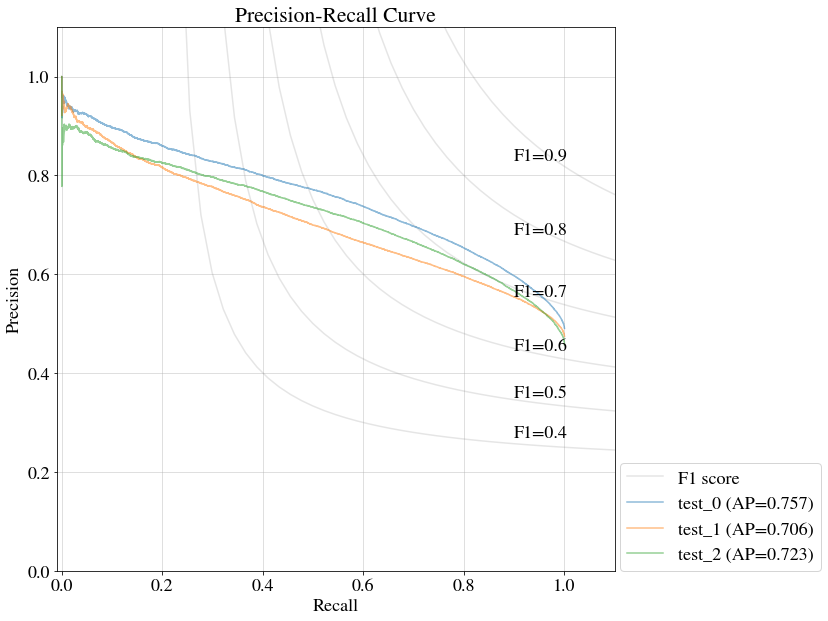

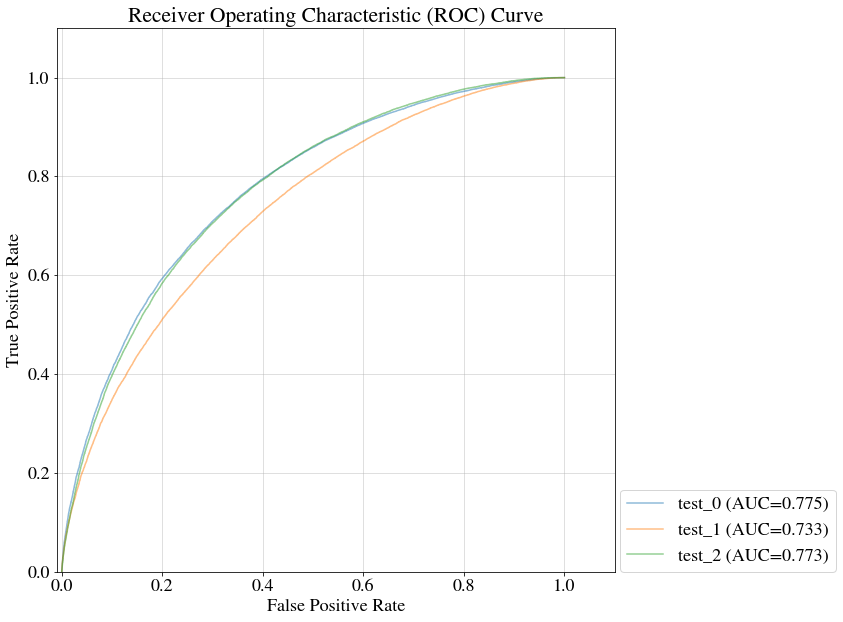

In [66]:
scores = []
classes = []

for j in range(1):
    for i in [.2,.5,.8]:    
        n, l = 10_000, 9

        y_score = (1-i)*np.random.rand(n,l) + i*np.arange(l).reshape((-1,l))/l
        scores.append(y_score)
        y_class = sp.stats.bernoulli.rvs(y_score)
        classes.append(y_class)

    
# y_score = y_class.mean(0)*np.ones_like(y_class)+np.random.rand(*y_class.shape)*.01
# y_class = sp.stats.bernoulli.rvs(y_score)
# scores.append(y_score)
# classes.append(y_class)
    
# y_score = sp.stats.bernoulli.rvs(y_class*0.9)+np.random.rand(*y_class.shape)*.01
# scores.append(y_score)
# classes.append(y_class)
    
pr_plot = PRCurvePlotter() 
for i in range(len(classes)):
    y_score, y_class = scores[i], classes[i]
    pr_plot.add_curve(
        y_class=y_class.flatten(), 
        y_score=y_score.flatten(), 
        label_name=f'test_{i}',
    ) 
pr_plot.show()

    
rc_plot = ROCCurvePlotter()
for i in range(len(classes)):
    y_score, y_class = scores[i], classes[i]
    rc_plot.add_curve(
        y_class=y_class.flatten(), 
        y_score=y_score.flatten(), 
        label_name=f'test_{i}',
    ) 
rc_plot.show()

In [67]:
y_class.shape,y_rank.shape

((10000, 9), (1000, 3))

In [68]:
def plot_interactive_roc(y_true, y_score, model_name='model'):

    fig = go.Figure(
        layout=dict(
            title_text="Receiver Operating Characteristic Curve",
            title_x=0.5,
            height=650,
            #         width=650,
            #         yaxis=dict(scaleanchor="x", scaleratio=1),
            yaxis_title='True Positive Rate',
            xaxis_title='False Positive Rate',
            yaxis=dict(range=[-0.01, 1.01]),
            xaxis=dict(range=[-0.01, 1.01]),
        ),
    )
    
    fpr, tpr, thresh = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)

    fig.add_trace(
        go.Scatter(
            y=tpr,
            x=fpr,
            name=f"{model_name} (AUC={auc:.3f})"
        )
    )

    return fig

def plot_interactive_pr(y_true, y_score, model_name='model'):

    fig = go.Figure(
        layout=dict(
            title_text="Precision Recall Curve",
            title_x=0.5,
            height=650,
            #         width=650,
            #         yaxis=dict(scaleanchor="x", scaleratio=1),
            yaxis_title='Precision',
            xaxis_title='Recall',
            yaxis=dict(range=[-0.01, 1.01]),
            xaxis=dict(range=[-0.01, 1.01]),
        ),
    )
    
    precision, recall, thresh = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    fig.add_trace(
        go.Scatter(
            y=precision,
            x=recall,
            name=f"{model_name} (AP={ap:.3f})"
        )
    )

    return fig

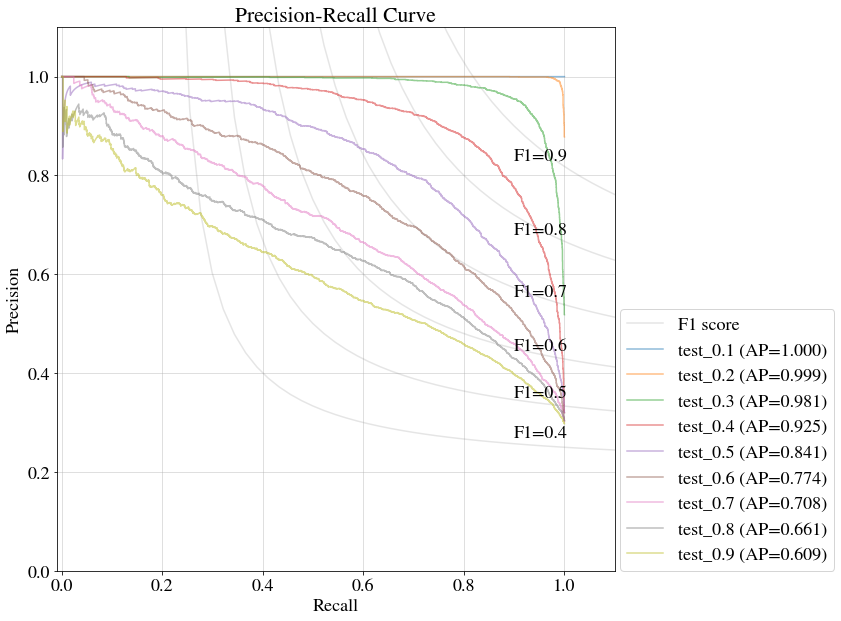

In [76]:
pr_plot = PRCurvePlotter()

for i in np.arange(.1,1,.1):
    i = np.round(i,decimals=1)

    y_class = np.random.binomial(1,.3,10000)
    y_score = np.random.randn(len(y_class))*i + y_class
    # y_score[y_score > 1] = 1

    pr_plot.add_curve(
        y_class=y_class, 
        y_score=y_score, 
        label_name=f'test_{i}',
    ) 
pr_plot.show()

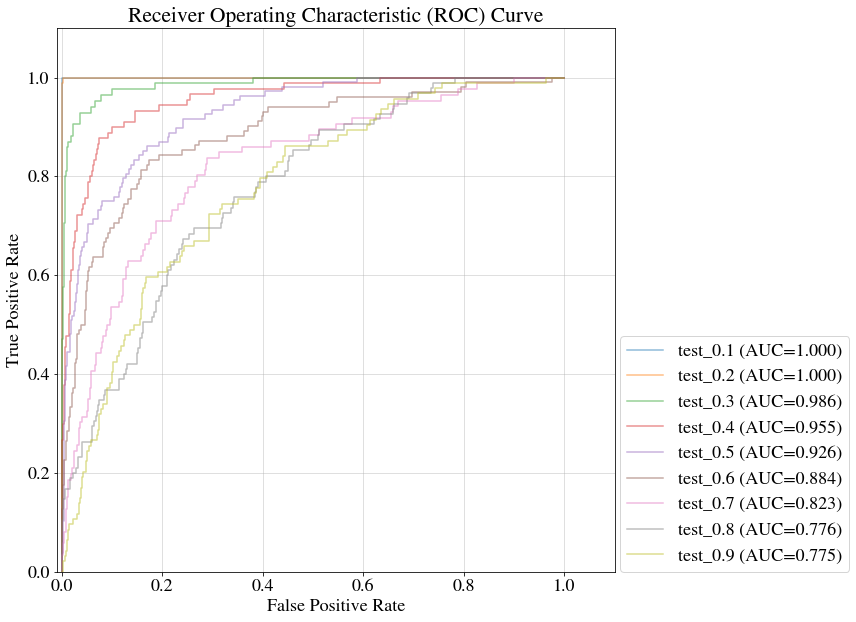

In [78]:
roc_plot = ROCCurvePlotter()

for i in np.arange(.1,1,.1):
    i = np.round(i,decimals=1)

    y_class = np.random.binomial(1,.1,1000)
    y_score = np.random.randn(len(y_class))*i + y_class
    # y_score[y_score > 1] = 1

    roc_plot.add_curve(
        y_class=y_class, 
        y_score=y_score, 
        label_name=f'test_{i}',
    ) 
roc_plot.show()

In [79]:
y_true = np.random.binomial(1,.5,10000)
y_score = np.random.randn(len(y_true))*0.9 + y_true
# y_score[y_score > 1] = 1
y_score

plot_interactive_pr(y_true, y_score)

# Distribution Differences

In [80]:
data = np.random.rand(10,7,5)
assert np.isclose(normalize_grid(data).sum(2).sum(1), np.ones(10)).all()

data = np.random.rand(10,7)
assert np.isclose(normalize_flat(data).sum(1), np.ones(10)).all()